# Importing Dependencies

In [42]:
# Task B2
import numpy as np
import pandas as pd
import yfinance as yf
import datetime as dt
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
import os

# Task B3
import plotly.graph_objects as go
import plotly.express as px

# Task B4
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN,LSTM, GRU, Dense, Dropout
import matplotlib.pyplot as plt
import sys

# Task B6
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf


# Hyperparameters

In [43]:
# Task B2
TICKER = "AAPL"
START_DATE = "2010-01-01"
END_DATE = "2018-03-31"
LOOK_UP_DAYS = 2
TRAINING_RATIO = 0.8    # 0.7 == 70%
SCALE_DATA = True
SCALING_METHOD = "MinMax"       # MinMax, Standard

# Task B3
TRADING_PERIOD = 60
CONSECUTIVE_DAYS = 300

# Task B4
NUMBER_OF_LAYER = 2
NUMBER_OF_HIDDEN_UNITS = 80
MODEL_NAME = "RNN"      ## "RNN". "LSTM", "GRU"
DROP_OUT_RATE = 0     ## dropout rate in [0,1]
NUMBER_OF_EPOCHS = 30
BATCH_SIZE = 12
FEATURE_PREDICT = "Close"    ## "Open", "High", "Close", "Low"
LOSS_FUNCTION = "mean_squared_error" ## "mean_squared_error", "mean_absolute_error", "huber_loss"
OPTIMIZER = "adam"  ## "adam", "RMSprop", "SGD"

# Task B6
ORDER = (LOOK_UP_DAYS, 1, 1)

# Task B2: DATA PROCESSING 1

### Scaling dataset

In [44]:
def DataScaler(stock_data, scaling_method=SCALING_METHOD):

    DatasetScaler = None
    ColumnScalers = {

    }
    if scaling_method == "MinMax":
        DatasetScaler = preprocessing.MinMaxScaler()


    elif scaling_method == "Standard":
        DatasetScaler = preprocessing.StandardScaler()


    # Learn the whole dataset
    col_names = stock_data.columns
    features = stock_data[col_names]
    DatasetScaler.fit(features.values)
    features = DatasetScaler.transform(features.values)
    scaledDataFrame = pd.DataFrame(features, columns = col_names)
    scaledDataFrame.index = stock_data.index

    for column in col_names:
        column_scaler = None
        if scaling_method == "MinMax":
            column_scaler = preprocessing.MinMaxScaler()
        elif scaling_method == "Standard":
            column_scaler = preprocessing.StandardScaler()
        column_scaler.fit(stock_data[column].values.reshape(-1,1))
        ColumnScalers[column] = column_scaler

    return scaledDataFrame, DatasetScaler, ColumnScalers


### Loading Data Function

In [45]:
def DataLoader(ticker=TICKER, start_date=START_DATE, end_date=END_DATE, scale=SCALE_DATA, scaling_method=SCALING_METHOD):
    '''
    ticker: is the code of the target ticker
    start_date: a start date string with format YYYY/MM/DD
    end_date: an end date string with format YYYY/MM/DD
    scale: a boolean value, True by default
    scaling_method: MinMax(by default), Standard.
    '''

    # result
    result = {
        "dataset": None,
        "datasetScaler": None,
        "columnScalers": None
    }

    # processing the input parameters
    start_date = dt.datetime.strptime(start_date, "%Y-%m-%d")
    end_date = dt.datetime.strptime(end_date, "%Y-%m-%d")


    # creating necessary folder
    if not os.path.isdir("results"):
        os.mkdir("results")

    if not os.path.isdir("data"):
        os.mkdir("data")



    # checking if the data is already downloaded
    ## Get a list of files in the directory
    files = os.listdir("data")
    ## Check each file in the directory
    data = None
    for file_name in files:
        ## if we already downloaded the ticket data
        if file_name.startswith(ticker) and file_name.endswith(".csv"):
            ### Read the file
            file_path = os.path.join("data", f"{ticker}.csv")
            data = pd.read_csv(file_path, parse_dates=['Date'])
            break

    ## else, we gonna download the stock data
    if data is None:
        stock_data = yf.download(ticker, start_date, end_date)
        file_path = os.path.join("data", f"{ticker}.csv")
        stock_data.to_csv(file_path)
        data = pd.read_csv(file_path, parse_dates=['Date'])

    # if the given time is included in the file, we just take the nessecary dataframe
    if data.head(1)["Date"].values[0] <= np.datetime64(start_date) and data.tail(1)["Date"].values[0] >= np.datetime64(end_date):
        data = data[(data['Date'] >= pd.to_datetime(start_date)) & (data['Date'] <= pd.to_datetime(end_date))]
        print("Local Stock Data is enough for requirements, do not need to download")
    else:
        stock_data = yf.download(ticker, start_date, end_date)
        file_path = os.path.join("data", f"{ticker}.csv")
        stock_data.to_csv(file_path)
        data = pd.read_csv(file_path, parse_dates=['Date'])
        print("Local Stock Data is not enough for requirements, continuing downloading...")

    # Setting Date as Index
    data.set_index('Date', inplace=True)

    # Scale Data
    if scale:
        data, scaler, column_scalers = DataScaler(data, scaling_method)
        result["dataset"] = data
        result["datasetScaler"] = scaler
        result["columnScalers"] = column_scalers
        return result

    result["dataset"] = data

    return result

### Splitting Dataset

In [46]:
def datasetSplitter(dataset: pd.DataFrame, look_up_days=LOOK_UP_DAYS,
        training_ratio=TRAINING_RATIO,
        feature_columns=['Open','High','Low','Close','Adj Close','Volume']):
    '''
    dataset: a Pandas Dataframe
    training_ratio: is equal to TRAINING_RATION constant
    '''
    # result
    splitResult = {
        "X_training_set": {
                        'Open': None,
                        'High': None,
                        'Low': None,
                        'Close': None,
                        'Adj Close': None,
                        'Volume': None
                        },
        "Y_training_set": {
                        'Open': None,
                        'High': None,
                        'Low': None,
                        'Close': None,
                        'Adj Close': None,
                        'Volume': None
                        },
        "X_testing_set": {
                        'Open': None,
                        'High': None,
                        'Low': None,
                        'Close': None,
                        'Adj Close': None,
                        'Volume': None
                        },
        "Y_testing_set": {
                        'Open': None,
                        'High': None,
                        'Low': None,
                        'Close': None,
                        'Adj Close': None,
                        'Volume': None
                        }
    }

    for column in feature_columns:
        dataset_in_column = dataset[column].values.reshape(-1, 1)      # <class 'numpy.ndarray'>
        x_data = []
        y_data = []

        for x in range(look_up_days, len(dataset_in_column)):
            x_data.append(dataset_in_column[x - look_up_days:x, 0])
            y_data.append(dataset_in_column[x, 0])

        splitResult["X_training_set"][column], splitResult["X_testing_set"][column], splitResult["Y_training_set"][column], splitResult['Y_testing_set'][column] = train_test_split(x_data, y_data, test_size=1-training_ratio, shuffle=False)

        ## Converting to numpy.array

        for column in feature_columns:
            splitResult["X_training_set"][column] = np.array(splitResult["X_training_set"][column])
            splitResult["Y_training_set"][column] = np.array(splitResult["Y_training_set"][column])
            splitResult["X_testing_set"][column] = np.array(splitResult["X_testing_set"][column])
            splitResult["Y_testing_set"][column] = np.array(splitResult["Y_testing_set"][column])

    return splitResult

## Data Processing 1 (FULL)

A function to load and process a dataset with multiple features with the following requirements:

+ Specify the start date and the end date for the whole
dataset as inputs.
+ Allowing you to deal with the NaN issue in the data
+ Splitting dataset according to some specified ratio of train/test
+ Storing the downloaded data on your local machine for future uses
+ Allowing you to have an option to scale your feature columns and store the scalers in a data structure to allow future access to these scalers.

In [49]:
def Data_Processing_1():
    dataLoader = DataLoader()

    scaledStockData = dataLoader["dataset"]
    datasetScaler = dataLoader["datasetScaler"]
    columnScalers = dataLoader["columnScalers"]

    dataset = datasetSplitter(dataset=scaledStockData)

    print("Loaded Done!\nThe result is a tuple as below:\n")
    print("(dataset, scaledStockData, datasetScaler, columnScalers), where:\n")
    print("dataset is a dictionary as below:")
    print('''{
        "X_training_set": {
                        'Open': <class 'numpy.ndarray'>,
                        'High': <class 'numpy.ndarray'>,
                        'Low': <class 'numpy.ndarray'>,
                        'Close': <class 'numpy.ndarray'>,
                        'Adj Close': <class 'numpy.ndarray'>,
                        'Volume': <class 'numpy.ndarray'>
                        },
        "Y_training_set": {
                        'Open': ...,
                        ...
                        },
        "X_testing_set": {
                        'Open': ...,
                        'High': ...,
                        ...
                        },
        "Y_testing_set": {
                        'Open': ...,
                        'High': ...,
                        'Low': ...,
                        ...
                        }
    }\n''')
    print("scaledStockData is a Pandas Dataframe of the Stock Ticker (scaled)\n")
    print("datasetScaler is the Scaler of the dataset\n")
    print("columnScalers is a dictionary: each key is a DataFrame Feature('Open', 'High', etc.) and the correspond value is a scaler of that feature")
    return dataset, scaledStockData, datasetScaler, columnScalers


In [50]:
dataset, scaledStockData, datasetScaler, ColumnScalers  = Data_Processing_1()

[*********************100%%**********************]  1 of 1 completed

Local Stock Data is not enough for requirements, continuing downloading...
Loaded Done!
The result is a tuple as below:

(dataset, scaledStockData, datasetScaler, columnScalers), where:

dataset is a dictionary as below:
{
        "X_training_set": {
                        'Open': <class 'numpy.ndarray'>,
                        'High': <class 'numpy.ndarray'>,
                        'Low': <class 'numpy.ndarray'>,
                        'Close': <class 'numpy.ndarray'>,
                        'Adj Close': <class 'numpy.ndarray'>,
                        'Volume': <class 'numpy.ndarray'>
                        },
        "Y_training_set": {
                        'Open': ...,
                        ...
                        },
        "X_testing_set": {
                        'Open': ...,
                        'High': ...,
                        ...
                        },
        "Y_testing_set": {
                        'Open': ...,
                        'High': ..

# Task B3: DATA PROCESSING 2

### Inverse Data

In [51]:
def datasetInverser(scaledStockData, datasetScaler):

    # Getting Column name
    col_names = scaledStockData.columns
    # Inversing the dataframe
    re_scaled_features = datasetScaler.inverse_transform(scaledStockData)
    re_scaled_stock_data = pd.DataFrame(re_scaled_features, columns = col_names)
    # Assigning index to the rescaled_data
    re_scaled_stock_data.index = scaledStockData.index


    ## A Pandas Dataframe
    return re_scaled_stock_data


### Candlestick Chart

In [52]:
def CandleStick(dataset, datascaler,TradingPeriod=TRADING_PERIOD):

    # Loading the dataset
    original_data = None
    # rescale the dataset if required
    if SCALE_DATA:
        original_data = datasetInverser(dataset, datascaler)

    else:
        original_data = dataset


    # Processed Data to fit the Trading Period
    total_records = len(original_data)
    Price_Data = {  'Date': [],
                    'Open': [],
                    'High': [],
                    'Low': [],
                    'Close': [],
                    'Volume': []
                }


    ## Loop through the DataFrame in batches of TradingPeriod
    for i in range(0, total_records, TradingPeriod):
        batch = original_data.iloc[i:i+TradingPeriod]

        Price_Data['Date'].append(batch.index[0])
        Price_Data['Open'].append(batch['Open'].values[0])
        Price_Data['High'].append(max(batch['High'].values))
        Price_Data['Low'].append(min(batch['Low'].values))
        Price_Data['Close'].append(batch['Close'].values[len(batch) - 1])
        Price_Data['Volume'].append(sum(batch['Volume'].values))


    # Converting to Pandas Dataframe
    NewDataFrame = pd.DataFrame(Price_Data)
    NewDataFrame.set_index('Date', inplace=True)

    NewDataFrame.info()
    fig = go.Figure(data=[go.Candlestick(x=NewDataFrame.index,
                open=NewDataFrame['Open'],
                high=NewDataFrame['High'],
                low=NewDataFrame['Low'],
                close=NewDataFrame['Close'])])

    fig.update_layout(
        title=f"Candle Stick Chart for {TICKER} shared price, Trading Period = {TRADING_PERIOD} day(s)",
        xaxis_title="Time",
        yaxis_title="Shared Price (USD)"
    )
    fig.show()


### Boxplot Chart

In [53]:
def BoxPlot(dataset, datascaler,ConsecutiveDays=CONSECUTIVE_DAYS, features=['Open', 'High', 'Low', 'Close']):

    original_data = None
    # rescale the dataset if required
    if SCALE_DATA:
        original_data = datasetInverser(dataset, datascaler)
    else:
        original_data = dataset

    total_records = len(original_data)

    consecutive_days_array = []
    ## Loop through the DataFrame in batches of ConsecutiveDays
    for i in range(0, total_records, ConsecutiveDays):
        batch = original_data.iloc[i:i+ConsecutiveDays]
        StartDate = batch.index[0].strftime('%Y-%m-%d')
        EndDate = batch.index[len(batch) - 1].strftime('%Y-%m-%d')

        consecutive_period = f"{StartDate} to {EndDate}"
        for _ in range(len(batch)):
            consecutive_days_array.append(consecutive_period)

    original_data['Consecutive'] = consecutive_days_array
    original_data['Consecutive'] = original_data['Consecutive'].astype("string")


    for feature in features:
        fig = px.box(original_data, x="Consecutive", y="Open")

        fig.update_layout(
        title=f"Boxplot Chart for {TICKER} shared price, Consecutive Days = {CONSECUTIVE_DAYS} day(s)",
        xaxis_title="Time",
        yaxis_title=f"{feature} Price (USD)"
        )
        fig.show()

## Task B3: Data Processing 2 (FULL)

In [54]:
def Data_Processing_2():
    CandleStick(scaledStockData, datasetScaler)

    BoxPlot(scaledStockData, datasetScaler)

# Task B6: Machine Learning 3

## Choosing $\texttt{LOOK\_UP\_DAYS}$

## Plotting the actual price of Apple Inc.

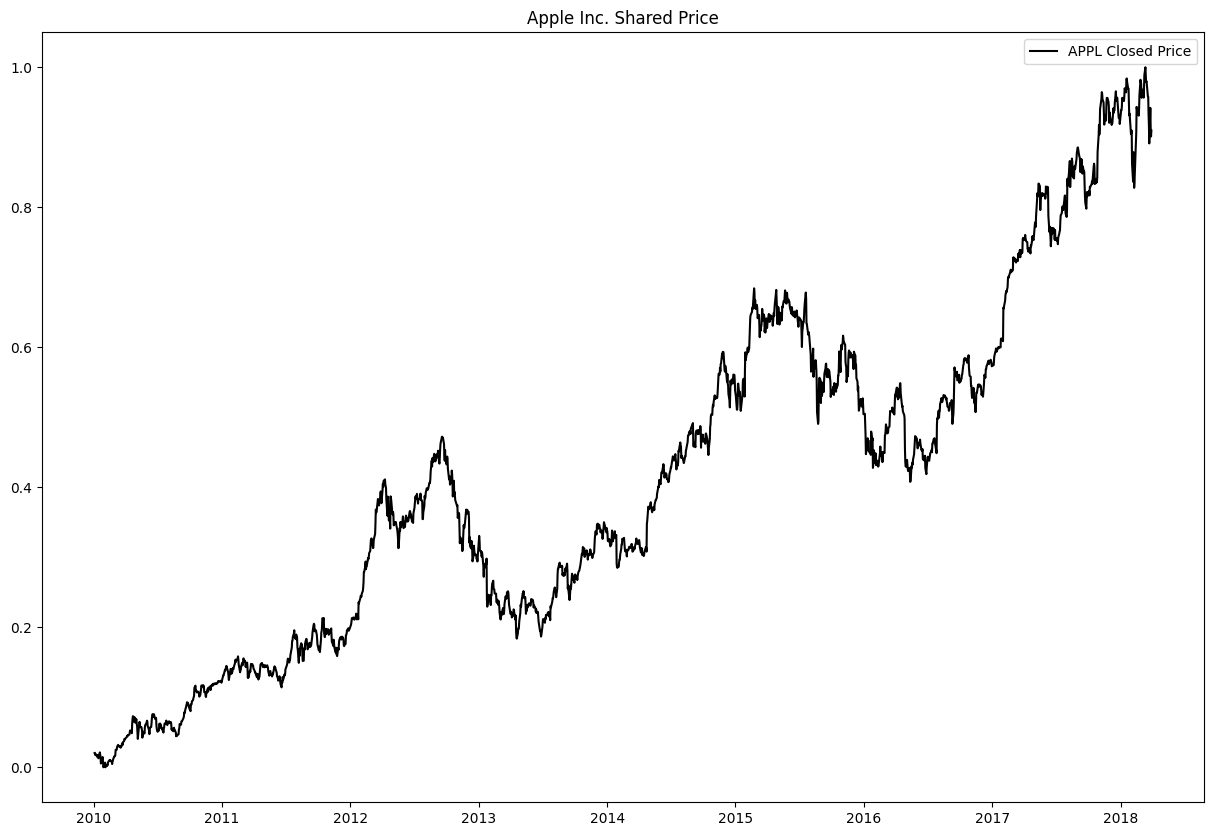

In [55]:
plt.figure(figsize=(15, 10))
plt.plot(scaledStockData["Close"], c="black", label="APPL Closed Price")
plt.legend()
plt.title("Apple Inc. Shared Price")
plt.show()

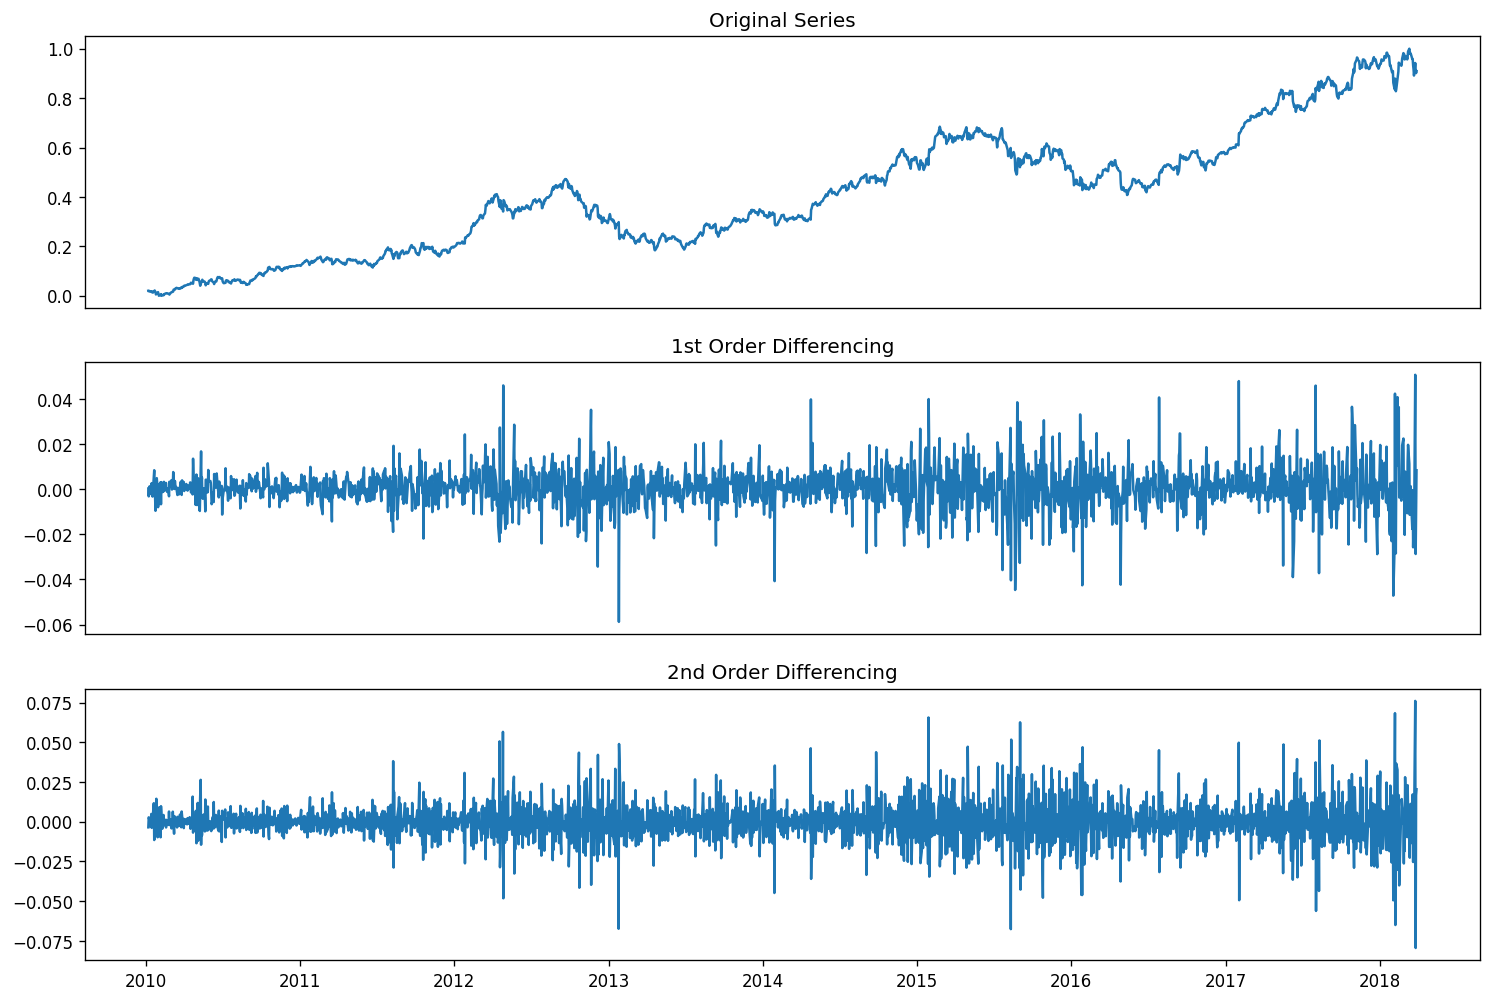

In [56]:
plt.rcParams.update({'figure.figsize':(15,10), 'figure.dpi':120})
 
# Original Series
fig, (ax1, ax2, ax3) = plt.subplots(3)
ax1.plot(scaledStockData["Close"]); ax1.set_title('Original Series'); ax1.axes.xaxis.set_visible(False)
# 1st Differencing
ax2.plot(scaledStockData["Close"].diff()); ax2.set_title('1st Order Differencing'); ax2.axes.xaxis.set_visible(False)
# 2nd Differencing
ax3.plot(scaledStockData["Close"].diff().diff()); ax3.set_title('2nd Order Differencing')
plt.show()

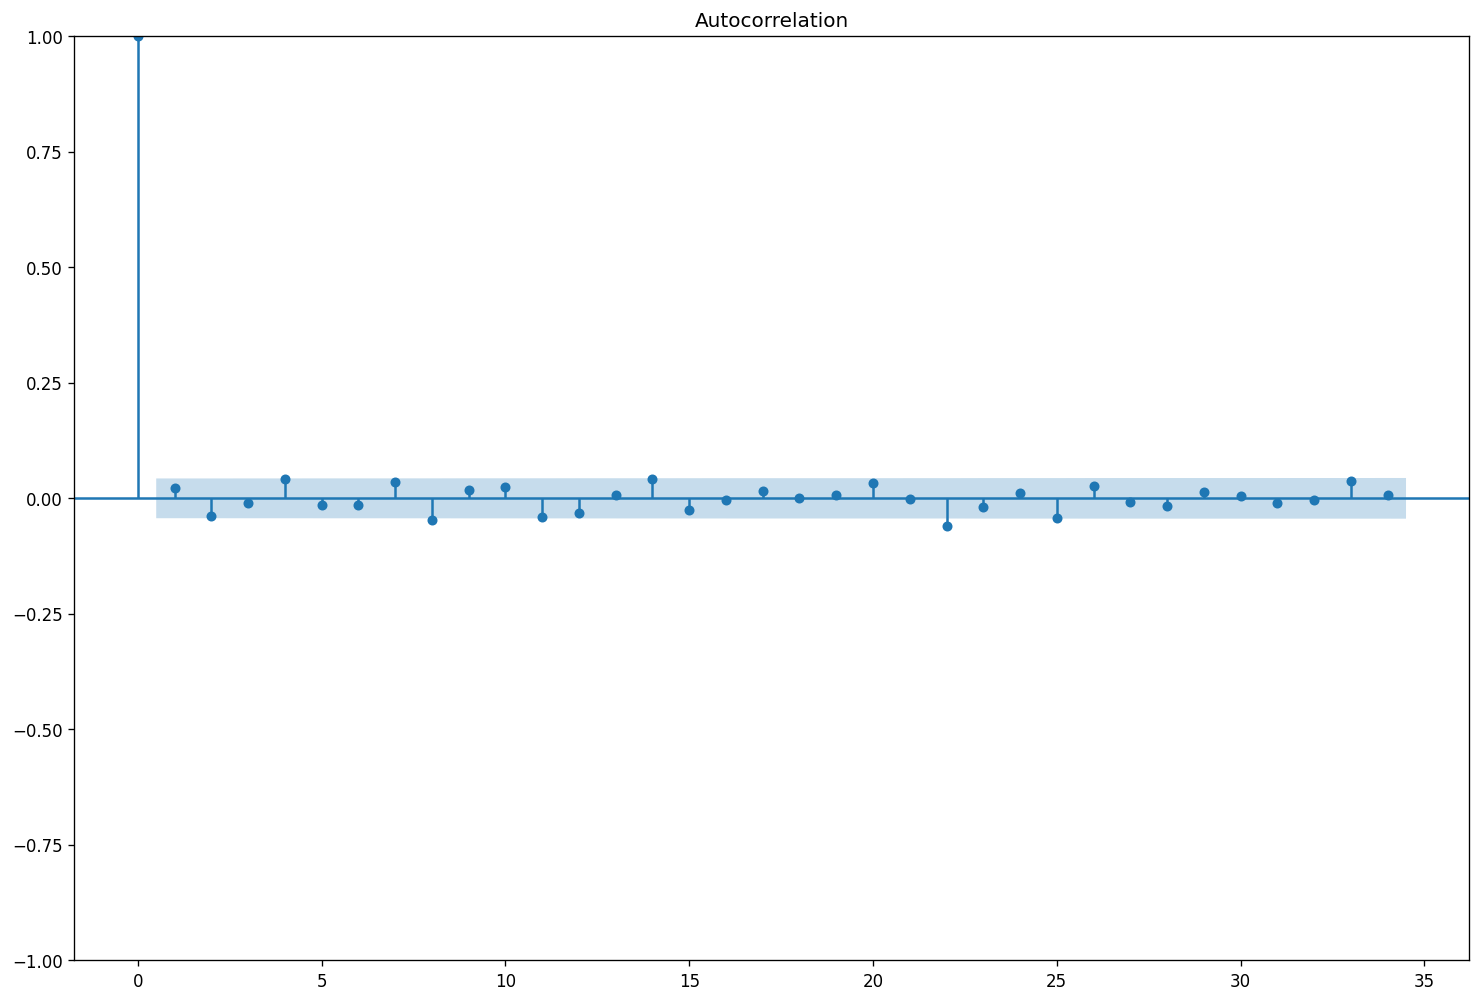

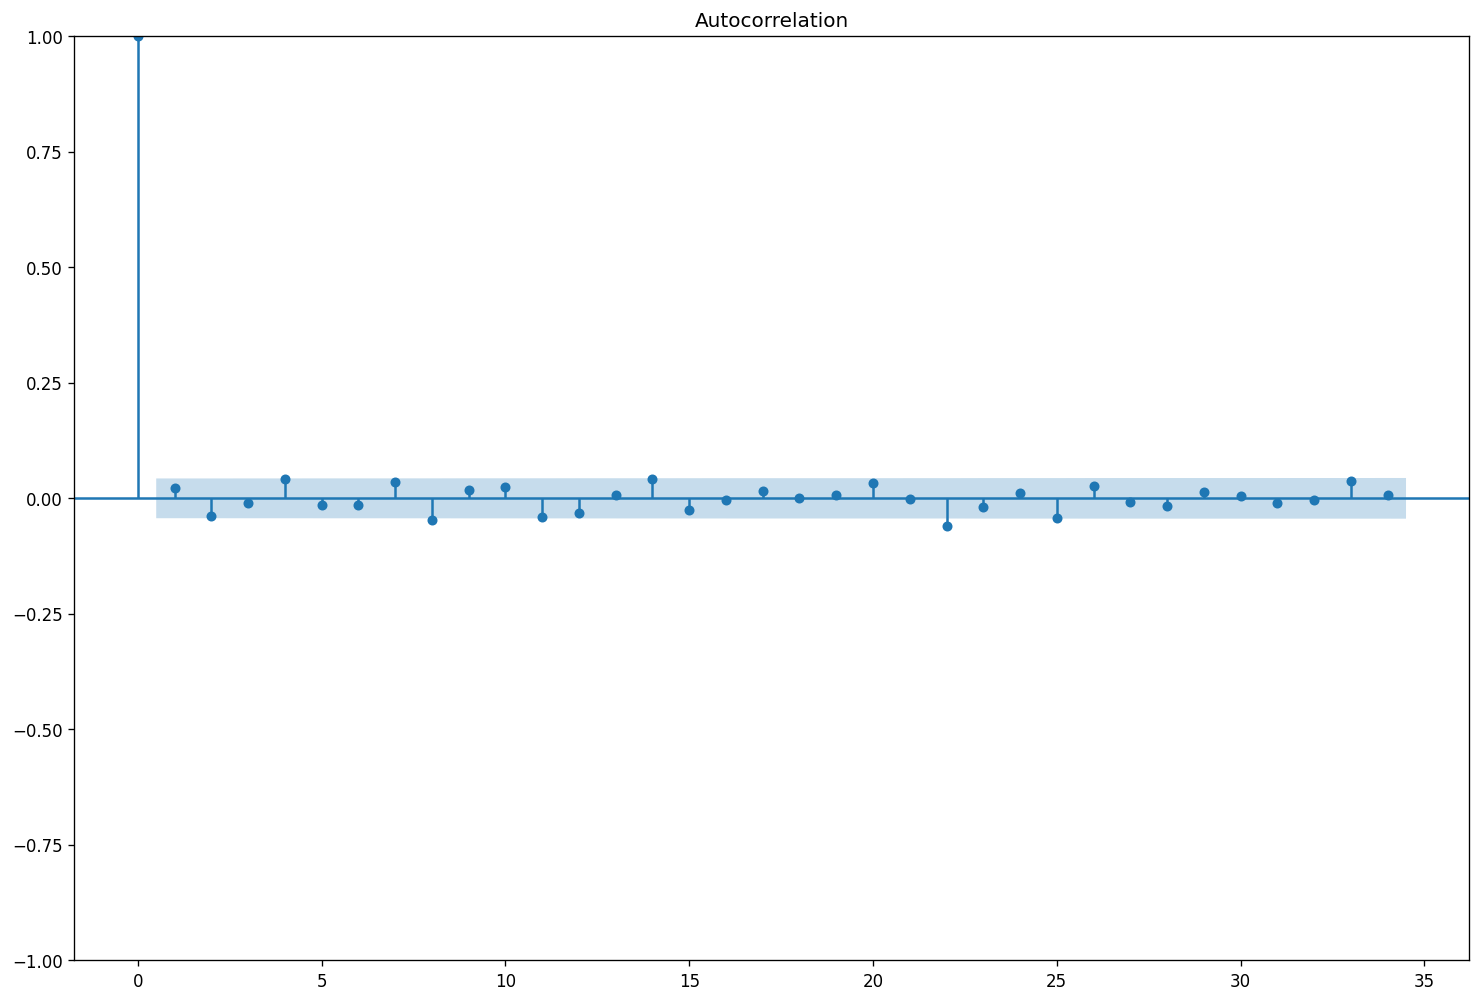

In [57]:
plot_acf(scaledStockData["Close"].diff().dropna())
# plot_pacf(scaledStockData["Close"].diff().dropna(), ax=ax2)

### Inversing A Column in the Dataset

In [58]:
def columnInverser(columnData, ColumnScaler):
    '''columnData: an np.array'''
    # transform the shape of the data
    reshaped_data = columnData.reshape(-1, 1)
    result = ColumnScaler.inverse_transform(reshaped_data)
    return result

### Plotting the Loss Error

In [59]:
def trainingErrorPloter(loss, validation):
    fig = plt.figure(figsize=(6, 4))
    plt.plot(loss, c="red", label = "training set")
    plt.plot(validation, c="blue", label = "validation set")
    plt.legend()
    plt.title(f"Training Error for {MODEL_NAME} Model")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    return fig

### Plotting Predicted Result

In [60]:
def predictedResultPloter(actual_value, predicted_value, arima, combined, feature):
    fig = plt.figure(figsize=(15, 8))
    plt.plot(actual_value, c="black", label = f"{TICKER} {feature} Price (Actual)")
    plt.plot(arima, c="red", label = f"ARIMA--{TICKER} {feature} Price (Actual)")
    plt.plot(predicted_value, c="green", label = f"{MODEL_NAME}--{TICKER} {feature} Price (Predicted)")
    plt.plot(combined, c="blue", label = f"Combine {MODEL_NAME} and ARIMA--{TICKER} {feature} Price (Predicted)")
    plt.legend()
    plt.title(f"{TICKER} shared price, LOOK_UP_DAYS={LOOK_UP_DAYS}")
    plt.xlabel("Time")
    plt.ylabel("Price")
    return fig

### Result Saver

In [61]:
def resultSaver(trainedModel,errorFig, predictedFig, modelName=MODEL_NAME):
    ## Get a list of foler in the results folders
    folders = os.listdir("results")

    if modelName not in folders:
        # Create the folder for the model
        folder_path = os.path.join("results", modelName)
        os.makedirs(folder_path)


    # Access the folder model folder and getting model list
    folder_path = os.path.join("results", modelName)
    modelLists = os.listdir(folder_path)

    # Creating a new folder to store the training infomation
    latestFolderName = "Model_" + str(len(modelLists))
    model_path = os.path.join(folder_path, latestFolderName)
    os.makedirs(model_path)

    # Saving Fig
    errorFig.savefig(os.path.join(model_path, "error.png"))
    predictedFig.savefig(os.path.join(model_path, "predictedResult.png"))

    # Saving model summary
    original_stdout = sys.stdout

    with open(os.path.join(model_path, "model_summary.txt"), 'w') as f:
        sys.stdout = f
        trainedModel.summary()

    sys.stdout = original_stdout

    ## Writing nessecary infomation to mode_summary.txt
    with open(os.path.join(model_path, "model_summary.txt"), 'a') as file:
        content = f'''
        NUMBER_OF_LAYER = {NUMBER_OF_LAYER} \n
        NUMBER_OF_HIDDEN_UNITS = {NUMBER_OF_HIDDEN_UNITS} \n
        NUMBER_OF_EPOCHS = {NUMBER_OF_EPOCHS}\n
        BATCH_SIZE = {BATCH_SIZE}\n
        FEATURE_PREDICT = "{FEATURE_PREDICT}"\n
        LOSS_FUNCTION = "{LOSS_FUNCTION}"\n
        OPTIMIZER = "{OPTIMIZER}"\n
        DROP_OUT_RATE = {DROP_OUT_RATE}    '''

        file.write(content)



### Recurrent Neural Networks (RNNs)

In [62]:
def RecurrentNeuralNetworks(layerNums=NUMBER_OF_LAYER,hidden_units=NUMBER_OF_HIDDEN_UNITS, loss_type=LOSS_FUNCTION, optimizerType=OPTIMIZER, dense_unit=1, activation=["tanh", "linear"], dropoutRate = DROP_OUT_RATE):
    model = Sequential()

    for i in range(layerNums):
        if i == (layerNums - 1):
            model.add(SimpleRNN(hidden_units, activation=activation[0]))
            model.add(Dropout(dropoutRate))
        else:
            model.add(SimpleRNN(hidden_units, activation=activation[0], return_sequences=True))
            model.add(Dropout(dropoutRate))

    model.add(Dense(units=dense_unit, activation=activation[1]))
    model.compile(loss=loss_type, optimizer=optimizerType)
    return model

### Long Short Term Memory (LSTM)

In [63]:
def LongShortTermMemory(layerNums=NUMBER_OF_LAYER,hidden_units=NUMBER_OF_HIDDEN_UNITS, loss_type=LOSS_FUNCTION, optimizerType=OPTIMIZER, dense_unit=1, activation=["tanh", "linear"], dropoutRate = DROP_OUT_RATE):
    model = Sequential()

    for i in range(layerNums):
        if i == (layerNums - 1):
            model.add(LSTM(hidden_units, activation=activation[0]))
            model.add(Dropout(dropoutRate))
        else:
            model.add(LSTM(hidden_units, activation=activation[1], return_sequences=True))
            model.add(Dropout(dropoutRate))

    model.add(Dense(units=dense_unit, activation=activation[1]))
    model.compile(loss=loss_type, optimizer=optimizerType)
    return model

### Gated Recurrent Unit (GRU)

In [64]:
def GatedRucurrentUnit(layerNums=NUMBER_OF_LAYER,hidden_units=NUMBER_OF_HIDDEN_UNITS, loss_type=LOSS_FUNCTION, optimizerType=OPTIMIZER, dense_unit=1, activation=["tanh", "linear"], dropoutRate = DROP_OUT_RATE):
    model = Sequential()

    for i in range(layerNums):
        if i == (layerNums - 1):
            model.add(GRU(hidden_units, activation=activation[0]))
            model.add(Dropout(dropoutRate))
        else:
            model.add(GRU(hidden_units, activation=activation[0], return_sequences=True))
            model.add(Dropout(dropoutRate))

    model.add(Dense(units=dense_unit, activation=activation[1]))
    model.compile(loss=loss_type, optimizer=optimizerType)
    return model

### Autoregressive Intergrated Moving Average (ARIMA)

In [65]:
def ARIMAmodel(train, test, _order=ORDER):
    history = [x for x in train]
    y_predict = []
    for t in range(len(test)):
        model = ARIMA(history, order=_order)
        model_fit = model.fit()
        output = model_fit.forecast()
        y_predict.append(output[0])
        obs = test[t]
        history.append(obs)
    return y_predict

In [66]:
def calculate_average(arr1, arr2):
    if len(arr1) != len(arr2):
        raise ValueError("Arrays must have the same length.")

    total_sum = (np.array(arr1) +np.array(arr2)) / 2
    return total_sum

# Example usage
array1 = [1, 2, 3, 4, 5]
array2 = [6, 7, 8, 9, 10]

result = calculate_average(array1, array2)
print("Average:", result)

Average: [3.5 4.5 5.5 6.5 7.5]


### Training Function

In [67]:
def Train(model, dataset, column_scalers, scaled=SCALE_DATA, num_epoc=NUMBER_OF_EPOCHS, batch=BATCH_SIZE, feature=FEATURE_PREDICT):


    ## Getting x_train, y_train, x_test, and y_test
    x_train = dataset["X_training_set"][feature]
    y_train = dataset["Y_training_set"][feature]
    x_test = dataset["X_testing_set"][feature]
    y_test = dataset["Y_testing_set"][feature]

    ## preprocessing training data
    x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))

    ## Training
    training_result = model.fit(x_train, y_train, epochs=num_epoc, batch_size=batch, validation_split=0.2)

    ## Plotting the error
    errorfig = trainingErrorPloter(training_result.history["loss"], training_result.history["val_loss"])

    ## Testing the result

    ### preprocessing the testing data
    x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))
    ### performing prediction
    predicted_y_test = model.predict(x_test)
    ### Inversing the data if required
    ARIMAresult = ARIMAmodel(y_train, y_test)
    ARIMAresult = np.array(ARIMAresult)
    
    ## Combine Prediction
    combinePrediction = None
    
    if scaled:
        y_test = columnInverser(y_test, column_scalers[feature])
        predicted_y_test = columnInverser(predicted_y_test, column_scalers[feature])
        ARIMAresult = columnInverser(ARIMAresult, column_scalers[feature])
    
    combinePrediction = ( predicted_y_test + ARIMAresult ) / 2
        
    ## Ploting the Predicted Result
    predictedResultFig = predictedResultPloter(y_test, predicted_y_test, ARIMAresult, combinePrediction, feature)


    resultSaver(model, errorfig, predictedResultFig)


## Task B6: Machine Learning 3 (FULL)

In [68]:
def Machine_Learning_3(dataset=dataset, column_scalers=ColumnScalers,modelName=MODEL_NAME):
    model = None

    if modelName == "RNN":
        model = RecurrentNeuralNetworks()
    elif modelName == "LSTM":
    #     ## TO DO
        model = LongShortTermMemory()
    elif modelName == "GRU":
        model = GatedRucurrentUnit()

    ## Performing Training and getting result
    Train(model, dataset, column_scalers)

Epoch 1/30
111/111 [==============================] - 3s 8ms/step - loss: 8.7435e-04 - val_loss: 3.9272e-04
Epoch 2/30
111/111 [==============================] - 0s 4ms/step - loss: 1.5019e-04 - val_loss: 0.0011
Epoch 3/30
111/111 [==============================] - 0s 4ms/step - loss: 1.5507e-04 - val_loss: 5.0360e-04
Epoch 4/30
111/111 [==============================] - 0s 4ms/step - loss: 1.4825e-04 - val_loss: 2.4411e-04
Epoch 5/30
111/111 [==============================] - 0s 3ms/step - loss: 1.4026e-04 - val_loss: 1.8795e-04
Epoch 6/30
111/111 [==============================] - 0s 3ms/step - loss: 1.1622e-04 - val_loss: 2.1439e-04
Epoch 7/30
111/111 [==============================] - 0s 3ms/step - loss: 1.1925e-04 - val_loss: 1.7402e-04
Epoch 8/30
111/111 [==============================] - 0s 4ms/step - loss: 1.3964e-04 - val_loss: 7.2321e-04
Epoch 9/30
111/111 [==============================] - 0s 3ms/step - loss: 1.3136e-04 - val_loss: 1.5963e-04
Epoch 10/30
111/111 [===========

c:\Users\Dell Precision\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\Dell Precision\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\Dell Precision\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\Dell Precision\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  war

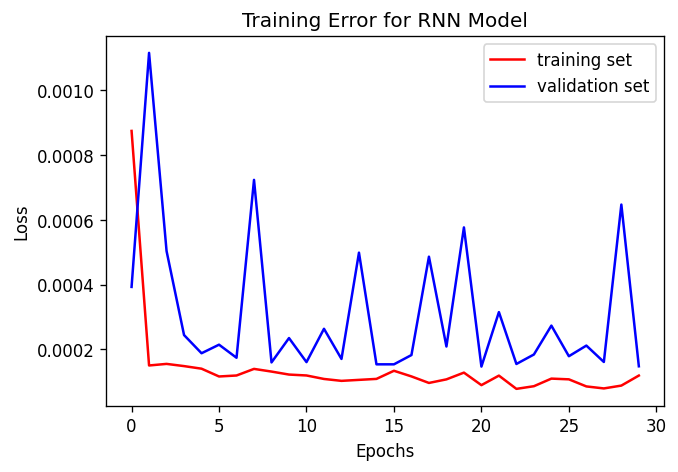

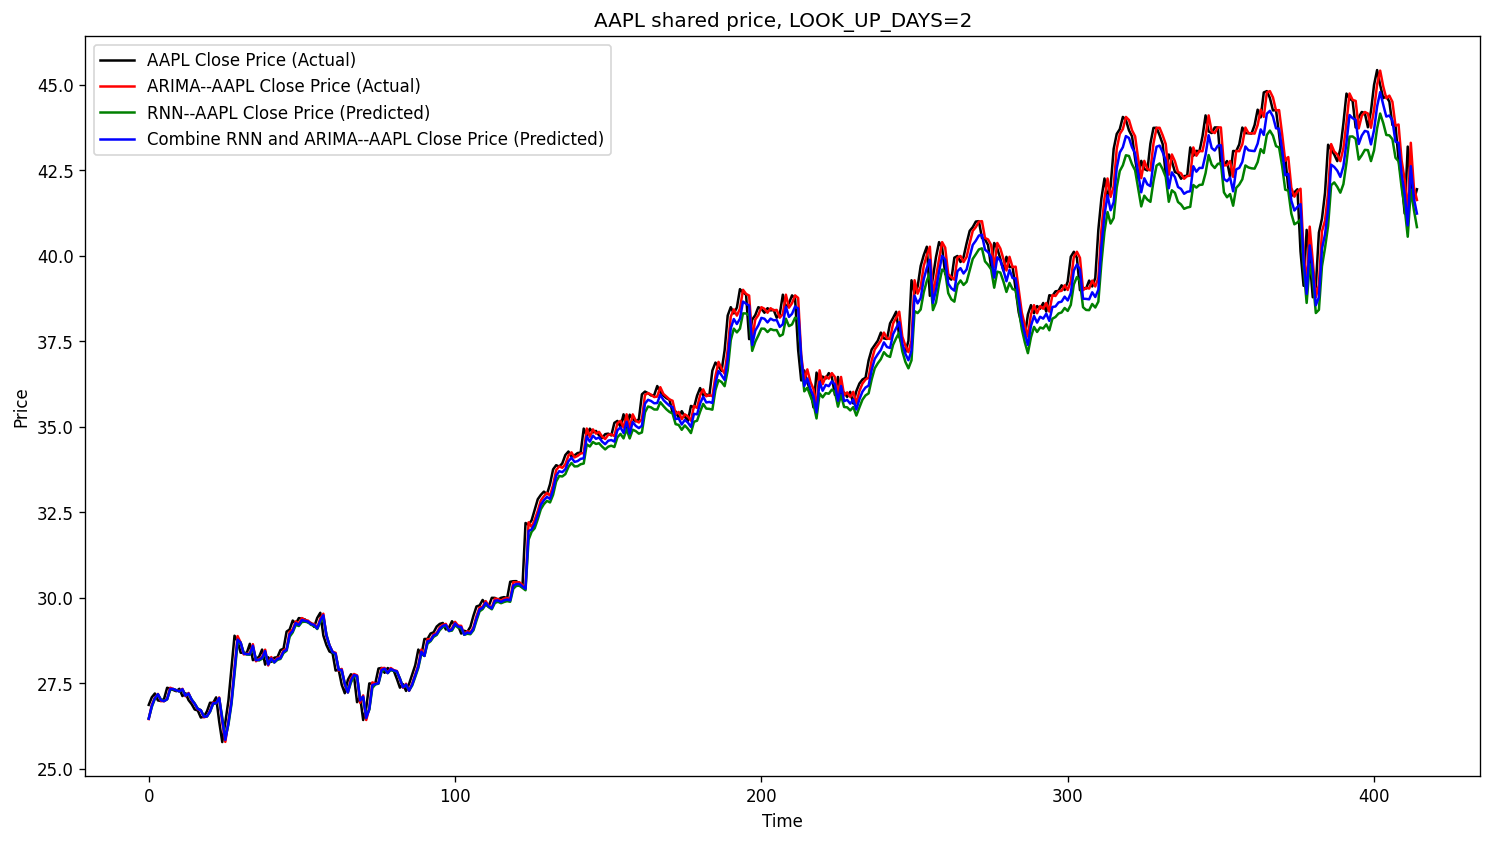

In [69]:
Machine_Learning_3()

In [132]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pandas_datareader as web
import datetime as dt

In [133]:
start = dt.datetime(2010, 1, 1)
end = dt.datetime(2021, 12, 31)
# data = web.DataReader('0050.TW', "yahoo", start=start, end=end)
data = yf.download('0050.TW', start=start, end=end)

[*********************100%%**********************]  1 of 1 completed


In [115]:
data.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2010-01-04,56.450001,56.650002,56.049999,56.500000,40.131134,20069
2010-01-05,56.799999,56.900002,56.150002,56.500000,40.131134,16430
2010-01-06,56.500000,57.750000,56.500000,57.549999,40.876934,18953
2010-01-07,57.599998,58.150002,57.299999,57.400002,40.770401,14101
2010-01-08,57.299999,57.750000,57.049999,57.750000,41.018990,11324


In [116]:
data['pct_change'] = (data['Close'] - data['Close'].shift(1))/ data['Close'].shift(1)
data['log_change'] = np.log(data['Close']/ data['Close'].shift(1))

In [117]:
from tools import technical_generator
Generator = technical_generator.Generator()

In [134]:
data['7ma'] = Generator.EMA(data['Close'], 7)
data['14ma'] = Generator.EMA(data['Close'], 14)
data['21ma'] = Generator.EMA(data['Close'], 21)
data['7macd'] = Generator.MACD(data['Close'], 3, 11, 7)
data['14macd'] = Generator.MACD(data['Close'], 7, 21, 14)
data['7rsi'] = Generator.RSI(data['Close'], 7)
data['14rsi'] = Generator.RSI(data['Close'], 14)
data['21rsi'] = Generator.RSI(data['Close'], 21)
data['7atr'] = Generator.atr(data['High'], data['Low'], 7)
data['14atr'] = Generator.atr(data['High'], data['Low'], 14)
data['21atr'] = Generator.atr(data['High'], data['Low'], 21)
data['7upper'], data['7lower'] = Generator.bollinger_band(data['Close'], 7)
data['14upper'], data['14lower'] = Generator.bollinger_band(data['Close'], 14)
data['21upper'], data['21lower'] = Generator.bollinger_band(data['Close'], 21)
data['7rsv'] = Generator.rsv(data['Close'], 7)
data['14rsv'] = Generator.rsv(data['Close'], 14)
data['21rsv'] = Generator.rsv(data['Close'], 21)

In [135]:
data.head()

,Open,High,Low,Close,Adj Close,Volume,7ma,14ma,21ma,7macd,...,21atr,7upper,7lower,14upper,14lower,21upper,21lower,7rsv,14rsv,21rsv
Date,,,,,,,,,,,,,,,,,,,,,
2010-01-04,56.450001,56.650002,56.049999,56.500000,40.131134,20069,56.500000,56.500000,56.500000,0.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2010-01-05,56.799999,56.900002,56.150002,56.500000,40.131134,16430,56.500000,56.500000,56.500000,0.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2010-01-06,56.500000,57.750000,56.500000,57.549999,40.876934,18953,56.954054,56.901103,56.883837,-0.079834,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2010-01-07,57.599998,58.150002,57.299999,57.400002,40.770401,14101,57.117143,57.053730,57.031868,-0.119616,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2010-01-08,57.299999,57.750000,57.049999,57.750000,41.018990,11324,57.324584,57.235386,57.204088,-0.163148,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [136]:
other_data = pd.read_csv('./data/other_data.csv', index_col = 'Date', parse_dates = True)
other_data.head()

,AAPL,MTK,GUC,Xintec,Qualcomm,SamSung,Broadcom,VIX,USD,CNY,...,NASDQ,dealer_buy,dealer_sell,dealer_dif,investment_buy,investment_sell,investment_dif,foreign_buy,foreign_sell,foreign_dif
Date,,,,,,,,,,,,,,,,,,,,,
2010-02-10,6.97,507.84,142.0,28.43,37.43,15100,16.80,25.40,32.06,0.15,...,2147.87,3161497580,2968407011,193090569,3102476560,1648311871,1454164689,1.551380e+10,2.549564e+10,-9981838210
2010-02-22,7.16,518.63,141.0,28.43,39.01,15460,17.35,19.94,32.00,0.15,...,2242.03,3133892869,2444166818,689726051,2130761100,1359109401,771651699,2.846749e+10,2.503619e+10,3431302085
2010-02-23,7.04,523.53,143.5,28.43,38.54,15340,17.38,21.37,32.06,0.15,...,2213.44,2000150200,2287498353,-287348153,2263043520,2650742656,-387699136,2.422218e+10,2.360860e+10,613580581
2010-02-24,7.17,517.65,146.5,28.43,37.87,15040,17.74,20.27,32.02,0.15,...,2235.90,2043898760,1998239251,45659509,2258613250,1775532693,483080557,2.027639e+10,2.546846e+10,-5192069643
2010-02-25,7.21,497.06,143.0,28.43,37.18,14720,18.09,20.10,32.04,0.15,...,2234.22,1728179056,3572176638,-1843997582,1801497370,2286138110,-484640740,2.259238e+10,3.143820e+10,-8845826819


In [137]:
other_data.index

DatetimeIndex(['2010-02-10', '2010-02-22', '2010-02-23', '2010-02-24',
               '2010-02-25', '2010-02-26', '2010-03-01', '2010-03-02',
               '2010-03-03', '2010-03-04',
               ...
               '2021-12-16', '2021-12-17', '2021-12-20', '2021-12-21',
               '2021-12-22', '2021-12-23', '2021-12-24', '2021-12-27',
               '2021-12-28', '2021-12-29'],
              dtype='datetime64[ns]', name='Date', length=2906, freq=None)

In [138]:
data_combine = data.merge(other_data, how = 'left', left_index = True, right_index = True)
data_combine

,Open,High,Low,Close,Adj Close,Volume,7ma,14ma,21ma,7macd,...,NASDQ,dealer_buy,dealer_sell,dealer_dif,investment_buy,investment_sell,investment_dif,foreign_buy,foreign_sell,foreign_dif
Date,,,,,,,,,,,,,,,,,,,,,
2010-01-04,56.450001,56.650002,56.049999,56.500000,40.131134,20069,56.500000,56.500000,56.500000,0.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2010-01-05,56.799999,56.900002,56.150002,56.500000,40.131134,16430,56.500000,56.500000,56.500000,0.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2010-01-06,56.500000,57.750000,56.500000,57.549999,40.876934,18953,56.954054,56.901103,56.883837,-0.079834,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2010-01-07,57.599998,58.150002,57.299999,57.400002,40.770401,14101,57.117143,57.053730,57.031868,-0.119616,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2010-01-08,57.299999,57.750000,57.049999,57.750000,41.018990,11324,57.324584,57.235386,57.204088,-0.163148,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-12-24,143.000000,143.600006,142.949997,143.050003,131.595215,12525381,142.101747,141.686840,141.348136,-0.401046,...,15653.37,7.654187e+09,6.711416e+09,9.427717e+08,2.817694e+09,3.380377e+09,-5.626823e+08,5.232482e+10,4.372264e+10,8.602180e+09
2021-12-27,143.199997,144.250000,143.100006,144.149994,132.607117,6512199,142.613809,142.015261,141.602850,-0.588790,...,15871.26,7.715526e+09,6.332401e+09,1.383125e+09,1.232269e+09,2.565483e+09,-1.333214e+09,5.322526e+10,4.213732e+10,1.108794e+10
2021-12-28,144.300003,145.300003,144.300003,145.300003,133.665054,22455995,143.285358,142.453226,141.938955,-0.841801,...,15781.72,8.558901e+09,6.831746e+09,1.727155e+09,2.205393e+09,1.660451e+09,5.449424e+08,6.966452e+10,4.810975e+10,2.155477e+10


In [140]:
data_combine = data_combine.dropna()
data_combine.head()

,Open,High,Low,Close,Adj Close,Volume,7ma,14ma,21ma,7macd,...,NASDQ,dealer_buy,dealer_sell,dealer_dif,investment_buy,investment_sell,investment_dif,foreign_buy,foreign_sell,foreign_dif
Date,,,,,,,,,,,,,,,,,,,,,
2010-02-10,51.950001,52.250000,51.700001,52.099998,37.005882,11219,51.943241,52.708595,53.263628,1.048469,...,2147.87,3.161498e+09,2.968407e+09,1.930906e+08,3.102477e+09,1.648312e+09,1.454165e+09,1.551380e+10,2.549564e+10,-9.981838e+09
2010-02-22,53.049999,53.150002,52.599998,52.599998,37.361023,11187,52.107470,52.693884,53.199239,0.848938,...,2242.03,3.133893e+09,2.444167e+09,6.897261e+08,2.130761e+09,1.359109e+09,7.716517e+08,2.846749e+10,2.503619e+10,3.431302e+09
2010-02-23,52.599998,52.750000,52.200001,52.599998,37.361023,9571,52.230624,52.681192,53.141451,0.653486,...,2213.44,2.000150e+09,2.287498e+09,-2.873482e+08,2.263044e+09,2.650743e+09,-3.876991e+08,2.422218e+10,2.360860e+10,6.135806e+08
2010-02-24,52.150002,52.549999,52.150002,52.250000,37.112411,11026,52.235469,52.623011,53.055956,0.515544,...,2235.90,2.043899e+09,1.998239e+09,4.565951e+07,2.258613e+09,1.775533e+09,4.830806e+08,2.027639e+10,2.546846e+10,-5.192070e+09
2010-02-25,52.250000,52.299999,51.349998,51.650002,36.686249,20361,52.089087,52.491931,52.921787,0.463497,...,2234.22,1.728179e+09,3.572177e+09,-1.843998e+09,1.801497e+09,2.286138e+09,-4.846407e+08,2.259238e+10,3.143820e+10,-8.845827e+09


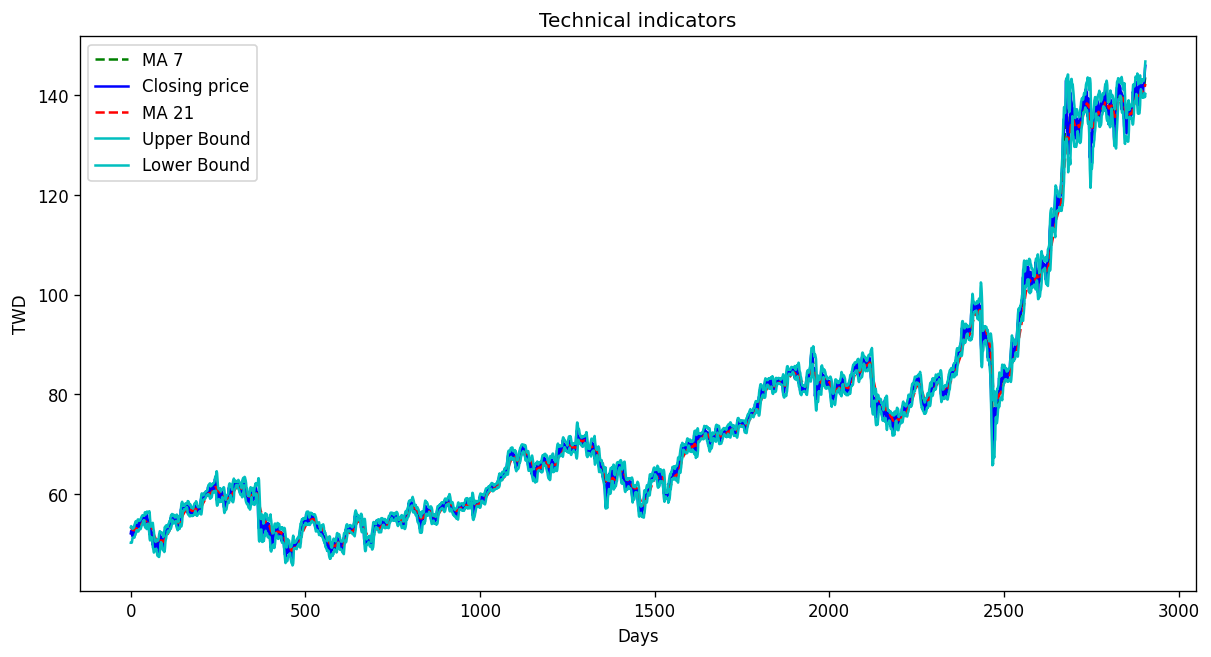

In [141]:
x_ = np.arange(data_combine.shape[0])
plt.figure(figsize=(12, 6))
plt.plot(data_combine['7ma'].values, label = 'MA 7', color = 'g', linestyle = '--')
plt.plot(data_combine['Close'].values, label = 'Closing price', color = 'b')
plt.plot(data_combine['21ma'].values, label = 'MA 21', color = 'r', linestyle = '--')
plt.plot(data_combine['7upper'].values, label = 'Upper Bound', color = 'c')
plt.plot(data_combine['7lower'].values, label = 'Lower Bound', color = 'c')
plt.fill_between(x_, data_combine['7lower'].values, data_combine['7upper'].values, alpha = 0.35)
plt.title('Technical indicators')
plt.ylabel('TWD')
plt.xlabel('Days')
plt.legend()

c:\Users\Dell Precision\AppData\Local\Programs\Python\Python310\lib\site-packages\matplotlib\cbook.py:1699: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
c:\Users\Dell Precision\AppData\Local\Programs\Python\Python310\lib\site-packages\matplotlib\cbook.py:1345: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
c:\Users\Dell Precision\AppData\Local\Programs\Python\Python310\lib\site-packages\matplotlib\cbook.py:1699: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
c:\Users\Dell Precision\AppData\Local\Programs\Python\Python310\lib\site-packages\matplotlib\cbook.py:1345: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
c:\Users\Dell Precision\AppData\Local\Programs\Python\Python310\lib\site-packages\matplotlib\cbook.py:1699: ComplexWarning: Casting complex values to re

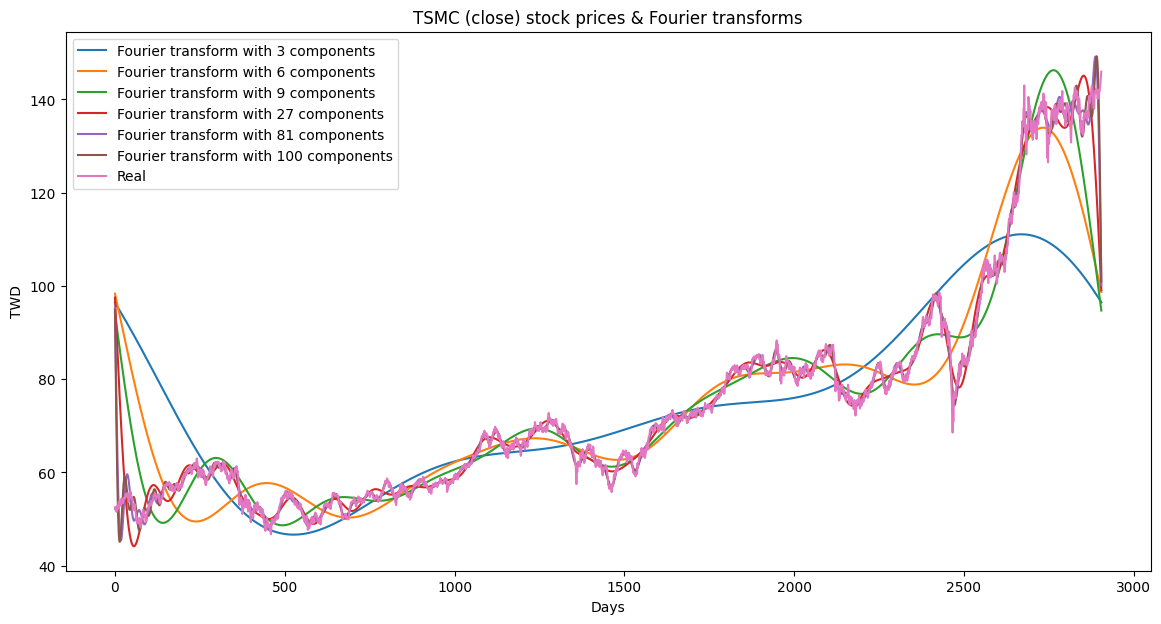

In [142]:
close_fft = np.fft.fft(np.asarray(data_combine['Close'].tolist()))
fft_df = pd.DataFrame({'fft':close_fft})
fft_df['absolute'] = fft_df['fft'].apply(lambda x: np.abs(x))
fft_df['angle'] = fft_df['fft'].apply(lambda x: np.angle(x))

plt.figure(figsize=(14, 7), dpi=100)
fft_list = np.asarray(fft_df['fft'].tolist())
for num_ in [3, 6, 9, 27, 81, 100]:
    fft_list_m10= np.copy(fft_list); fft_list_m10[num_:-num_] = 0
    data_combine[f'FT_{num_}components'] = np.fft.ifft(fft_list_m10)
    plt.plot(np.fft.ifft(fft_list_m10), label='Fourier transform with {} components'.format(num_))
plt.plot(data_combine['Close'].values,  label='Real')
plt.xlabel('Days')
plt.ylabel('TWD')
plt.title('TSMC (close) stock prices & Fourier transforms')
plt.legend()
plt.show()

In [143]:
data_combine.to_csv('./data/data.csv')